Задача прогнозирования среднего чека покупки (временные ряды).

In [1]:
# обработка
import numpy as np
import pandas as pd
import datetime as dt

# визуализация 
import matplotlib.pyplot as plt
%matplotlib inline

# моделирование
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX 

In [2]:
# загрузим данные и посмотрим их вид

df = pd.read_excel('D:\\Work\\data\\online_retail\\online_retail_o2.xlsx')
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country
0,539993,20682,RED RETROSPOT CHILDRENS UMBRELLA,6,2019-01-04 10:00:00,27.85,Russia
1,539993,20718,RED RETROSPOT SHOPPER BAG,10,2019-01-04 10:00:00,10.71,Russia
2,539993,21498,RED RETROSPOT WRAP,25,2019-01-04 10:00:00,3.60,Russia
3,539993,21499,BLUE POLKADOT WRAP,25,2019-01-04 10:00:00,3.60,Russia
4,539993,22302,COFFEE MUG PEARS DESIGN,6,2019-01-04 10:00:00,21.85,Russia
5,539993,22303,COFFEE MUG APPLES DESIGN,6,2019-01-04 10:00:00,21.85,Russia
6,539993,22379,RECYCLING BAG RETROSPOT,5,2019-01-04 10:00:00,17.99,Russia
7,539993,22386,JUMBO BAG PINK POLKADOT,10,2019-01-04 10:00:00,16.71,Russia
8,539993,22458,CAST IRON HOOK GARDEN FORK,8,2019-01-04 10:00:00,21.85,Russia
9,539993,22667,RECIPE BOX RETROSPOT,6,2019-01-04 10:00:00,25.28,Russia


In [3]:
# посмотрим распределение количества заказов/счетов по странам

df['Invoice'].groupby(df['Country']).nunique()

Country
Belarus      106
Others      1763
Russia     22411
Ukraine      446
Name: Invoice, dtype: int64

In [4]:
# нас интересует только Россия, остальные страны удалим

df = df[df['Country'] == 'Russia']
df.reset_index(inplace = True, drop = True)
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country
0,539993,20682,RED RETROSPOT CHILDRENS UMBRELLA,6,2019-01-04 10:00:00,27.85,Russia
1,539993,20718,RED RETROSPOT SHOPPER BAG,10,2019-01-04 10:00:00,10.71,Russia
2,539993,21498,RED RETROSPOT WRAP,25,2019-01-04 10:00:00,3.60,Russia
3,539993,21499,BLUE POLKADOT WRAP,25,2019-01-04 10:00:00,3.60,Russia
4,539993,22302,COFFEE MUG PEARS DESIGN,6,2019-01-04 10:00:00,21.85,Russia
...,...,...,...,...,...,...,...
479597,514212,22457,NATURAL SLATE HEART CHALKBOARD,12,2019-12-30 17:04:00,84.25,Russia
479598,514212,22457,NATURAL SLATE HEART CHALKBOARD,12,2019-12-30 17:04:00,84.25,Russia
479599,514212,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,16,2019-12-30 17:04:00,18.56,Russia
479600,514212,84795C,OCEAN STRIPE HAMMOCK,1,2019-12-30 17:04:00,227.05,Russia


In [5]:
# посмотрим, что с данными в целом

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479602 entries, 0 to 479601
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      479602 non-null  int64         
 1   StockCode    479602 non-null  object        
 2   Description  479602 non-null  object        
 3   Quantity     479602 non-null  int64         
 4   InvoiceDate  479602 non-null  datetime64[ns]
 5   Price        479602 non-null  float64       
 6   Country      479602 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 25.6+ MB


In [6]:
# добавим столбец только с датой без времени

df['InvoiceDate_Day'] =  df['InvoiceDate'].dt.date

In [7]:
# посчитаем общие суммы каждого товара в заказе

df['SumPrice'] = df['Quantity'] * df['Price']
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,InvoiceDate_Day,SumPrice
0,539993,20682,RED RETROSPOT CHILDRENS UMBRELLA,6,2019-01-04 10:00:00,27.85,Russia,2019-01-04,167.10
1,539993,20718,RED RETROSPOT SHOPPER BAG,10,2019-01-04 10:00:00,10.71,Russia,2019-01-04,107.10
2,539993,21498,RED RETROSPOT WRAP,25,2019-01-04 10:00:00,3.60,Russia,2019-01-04,90.00
3,539993,21499,BLUE POLKADOT WRAP,25,2019-01-04 10:00:00,3.60,Russia,2019-01-04,90.00
4,539993,22302,COFFEE MUG PEARS DESIGN,6,2019-01-04 10:00:00,21.85,Russia,2019-01-04,131.10
...,...,...,...,...,...,...,...,...,...
479597,514212,22457,NATURAL SLATE HEART CHALKBOARD,12,2019-12-30 17:04:00,84.25,Russia,2019-12-30,1011.00
479598,514212,22457,NATURAL SLATE HEART CHALKBOARD,12,2019-12-30 17:04:00,84.25,Russia,2019-12-30,1011.00
479599,514212,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,16,2019-12-30 17:04:00,18.56,Russia,2019-12-30,296.96
479600,514212,84795C,OCEAN STRIPE HAMMOCK,1,2019-12-30 17:04:00,227.05,Russia,2019-12-30,227.05


In [8]:
# для расчета среднего чека за каждый день

df[['InvoiceDate_Day', 'SumPrice']].groupby(['InvoiceDate_Day'])['SumPrice'].sum() # общая сумма покупок за день
df[['InvoiceDate_Day', 'Invoice']].groupby(['InvoiceDate_Day'])['Invoice'].nunique() # количество покупок за день 

InvoiceDate_Day
2019-01-04    34
2019-01-05    46
2019-01-06    42
2019-01-07    40
2019-01-09    44
              ..
2019-12-25    36
2019-12-27    55
2019-12-28    59
2019-12-29    56
2019-12-30    66
Name: Invoice, Length: 317, dtype: int64

In [9]:
# расчет среднего чека в день

df_mean_invoice = (df[['InvoiceDate_Day', 'SumPrice']].groupby(['InvoiceDate_Day'])['SumPrice'].sum() /
    df[['InvoiceDate_Day', 'Invoice']].groupby(['InvoiceDate_Day'])['Invoice'].nunique())

df_mean_invoice = pd.DataFrame({'InvoiceDate_Day': df_mean_invoice.index, 'Mean_inv': df_mean_invoice.values})
df_mean_invoice['InvoiceDate_Day'] = pd.to_datetime(df_mean_invoice['InvoiceDate_Day'], format='%Y-%m-%d') # object в datetime64
df_mean_invoice.set_index('InvoiceDate_Day', inplace=True)
df_mean_invoice

,Mean_inv
InvoiceDate_Day,
2019-01-04,2914.907353
2019-01-05,5102.343043
2019-01-06,5386.605714
2019-01-07,3773.894500
2019-01-09,2785.841818
...,...
2019-12-25,8575.448611
2019-12-27,9780.252545
2019-12-28,15214.470169


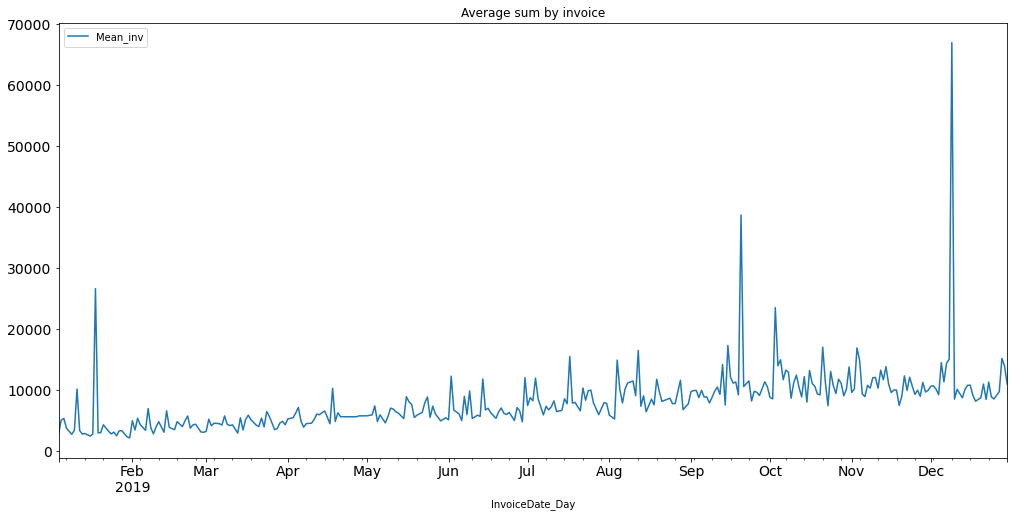

In [10]:
# посмотрим график среднего чека по месяцам - есть выбросы 

df_mean_invoice.reset_index(inplace=True)
df_mean_invoice[['InvoiceDate_Day', 'Mean_inv']].groupby(df_mean_invoice['InvoiceDate_Day'].dt.to_period('D')).mean().plot(figsize = (17,8), title = 'Average sum by invoice', fontsize = 14)

In [11]:
# выбросы мы заменим средним значением соответствующего месяца, за выброс примем значение в 1.8 раза более среднего за месяц

df_outlier = df_mean_invoice
df_outlier = df_outlier.groupby(df_outlier['InvoiceDate_Day'].dt.to_period('M')).mean() * 1.8 # среднее за месяц * 1.8
df_outlier

,Mean_inv
InvoiceDate_Day,
2019-01,8111.498471
2019-02,7779.792116
2019-03,8282.047167
2019-04,10395.689536
2019-05,11619.750097
2019-06,12637.264311
2019-07,15016.741663
2019-08,16631.917807
2019-09,20209.766328


In [12]:
# заменим выбросы средним за месяц

for i in df_outlier.index:
    mean_inv = df_outlier[str(i)].values[0, 0]
    df_mean_invoice['Mean_inv'].loc[(df_mean_invoice['InvoiceDate_Day'].dt.to_period('M') == str(i)) 
                    & (df_mean_invoice['Mean_inv'] >= df_outlier[str(i)].values[0, 0])] = df_outlier[str(i)].values[0, 0] / 1.8
    print('Период:', i, 'Порог выброса:', mean_inv, 'Среднее по месяцу:', mean_inv / 1.8, sep=' ')

Период: 2019-01 Порог выброса: 8111.498471189314 Среднее по месяцу: 4506.388039549619
Период: 2019-02 Порог выброса: 7779.79211568837 Среднее по месяцу: 4322.106730937983
Период: 2019-03 Порог выброса: 8282.047167036417 Среднее по месяцу: 4601.137315020232
Период: 2019-04 Порог выброса: 10395.689535852061 Среднее по месяцу: 5775.383075473367
Период: 2019-05 Порог выброса: 11619.75009652182 Среднее по месяцу: 6455.4167202899
Период: 2019-06 Порог выброса: 12637.264310936995 Среднее по месяцу: 7020.7023949649965
Период: 2019-07 Порог выброса: 15016.741663047314 Среднее по месяцу: 8342.634257248508
Период: 2019-08 Порог выброса: 16631.917806653713 Среднее по месяцу: 9239.95433702984
Период: 2019-09 Порог выброса: 20209.7663277201 Среднее по месяцу: 11227.647959844498
Период: 2019-10 Порог выброса: 20839.709328797413 Среднее по месяцу: 11577.61629377634
Период: 2019-11 Порог выброса: 19575.217660318445 Среднее по месяцу: 10875.120922399135
Период: 2019-12 Порог выброса: 23131.393302551558 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


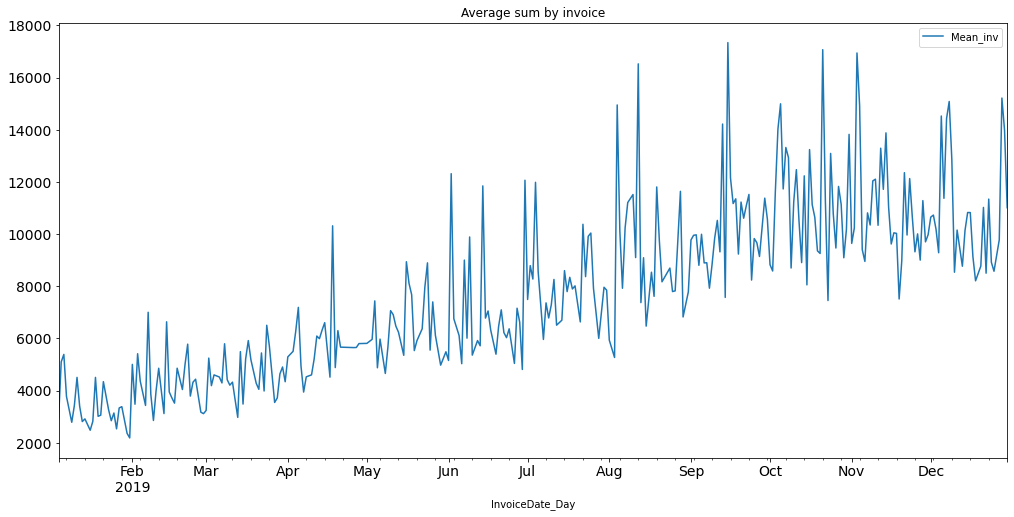

In [13]:
# посмотрим график среднего чека по месяцам - есть выбросы 

df_mean_invoice.reset_index(inplace=True, drop=True)
df_mean_invoice[['InvoiceDate_Day', 'Mean_inv']].groupby(df_mean_invoice['InvoiceDate_Day'].dt.to_period('D')).mean().plot(figsize = (17,8), title = 'Average sum by invoice', fontsize = 14)

In [14]:
# ещё есть пропущенные даты: 365 - 317 = 48, добавим строки недостяющих дат

df_days = pd.DataFrame({'Mean_inv':[0 for i in range(365)]}, index = pd.date_range('2019-01-01', '2019-12-31', freq='D'))
df_mean_invoice.set_index('InvoiceDate_Day', inplace=True) # df полного календаря
df_mean_invoice = df_mean_invoice.join(df_days, rsuffix='_', how='outer').iloc[:, 0] # объединим df рабочий и df полного календаря
df_mean_invoice = pd.DataFrame({'InvoiceDate_Day': df_mean_invoice.index, 'Mean_inv': df_mean_invoice.values}) 
df_mean_invoice = df_mean_invoice.set_index('InvoiceDate_Day')
df_mean_invoice

,Mean_inv
InvoiceDate_Day,
2019-01-01,NaN
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,2914.907353
2019-01-05,5102.343043
...,...
2019-12-27,9780.252545
2019-12-28,15214.470169
2019-12-29,13983.524286


In [15]:
# посчитаем среднее для каждого месяца

df_mean_invoice.reset_index(inplace=True)
df_mean_invoice_avg = df_mean_invoice.groupby(df_mean_invoice['InvoiceDate_Day'].dt.to_period('M')).mean() 
df_mean_invoice_avg

,Mean_inv
InvoiceDate_Day,
2019-01,3346.056296
2019-02,4322.106731
2019-03,4601.137315
2019-04,5775.383075
2019-05,6455.416720
2019-06,7020.702395
2019-07,8065.548996
2019-08,9239.954337
2019-09,10310.808192


In [16]:
# восстановим данные дней - заменим пустые средним значение за соответствующий месяц

for i in df_mean_invoice_avg.index:
    mean_inv_avg = df_mean_invoice_avg[str(i)].values[0, 0]
    df_mean_invoice['Mean_inv'].loc[(df_mean_invoice['InvoiceDate_Day'].dt.to_period('M') == str(i)) 
                                        & (df_mean_invoice['Mean_inv'].isna())] = df_mean_invoice_avg[str(i)].values[0, 0]
    print('Период:', i, 'Среднее по месяцу:', mean_inv_avg, sep=' ')

Период: 2019-01 Среднее по месяцу: 3346.05629593184
Период: 2019-02 Среднее по месяцу: 4322.106730937983
Период: 2019-03 Среднее по месяцу: 4601.137315020232
Период: 2019-04 Среднее по месяцу: 5775.383075473367
Период: 2019-05 Среднее по месяцу: 6455.4167202899
Период: 2019-06 Среднее по месяцу: 7020.7023949649965
Период: 2019-07 Среднее по месяцу: 8065.548996123004
Период: 2019-08 Среднее по месяцу: 9239.95433702984
Период: 2019-09 Среднее по месяцу: 10310.808192385766
Период: 2019-10 Среднее по месяцу: 11191.354712202012
Период: 2019-11 Среднее по месяцу: 10875.120922399135
Период: 2019-12 Среднее по месяцу: 10845.453922331035


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
df_mean_invoice

,InvoiceDate_Day,Mean_inv
0,2019-01-01,3346.056296
1,2019-01-02,3346.056296
2,2019-01-03,3346.056296
3,2019-01-04,2914.907353
4,2019-01-05,5102.343043
...,...,...
360,2019-12-27,9780.252545
361,2019-12-28,15214.470169
362,2019-12-29,13983.524286
363,2019-12-30,11010.602121


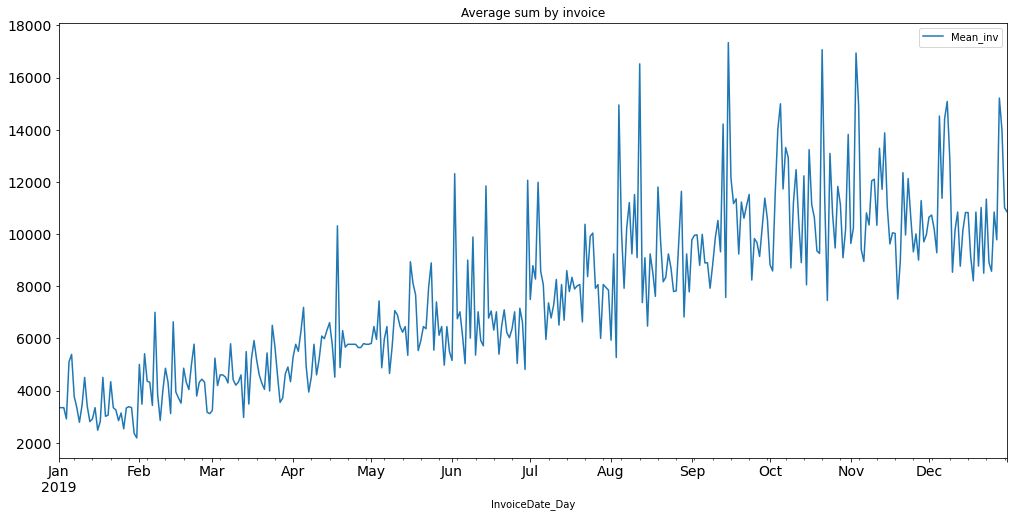

In [18]:
# посмотрим график среднего чека по месяцам - есть выбросы 

df_mean_invoice[['InvoiceDate_Day', 'Mean_inv']].groupby(df_mean_invoice['InvoiceDate_Day'].dt.to_period('D')).mean().plot(figsize = (17,8), title = 'Average sum by invoice', fontsize = 14)

In [19]:
# разделим исторические данные на трейн и тест (20%)

df_mean_invoice.set_index('InvoiceDate_Day', inplace=True)
train, test = train_test_split(df_mean_invoice, test_size=0.2, random_state=13, shuffle=False)

In [20]:
# используем несколько подходов и выберем лучший 

models_quality_rmse = {}

Метод 1: начинаем с наивного подхода

Text(0.5, 1.0, 'Naive Forecast')

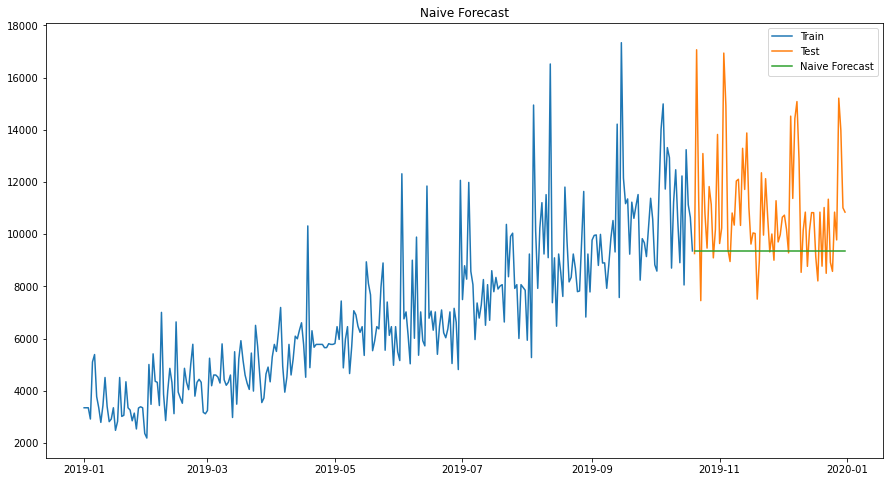

In [21]:
# исходим, что последняя точка будет всегда

dd=np.asarray(train['Mean_inv'])
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(15,8))
plt.plot(train.index, train['Mean_inv'], label='Train')
plt.plot(test.index, test['Mean_inv'], label='Test')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Naive Forecast')

In [22]:
rms = sqrt(mean_squared_error(test['Mean_inv'], y_hat['naive']))
models_quality_rmse['native'] = rms
rms # rmse говорит о том, что для наивного подхода данные слишком изменчивы, 
# но может подойти для стабильных данных

2573.30912537042

Метод 2. Простое среднее.

Text(0.5, 1.0, 'Average Forecast')

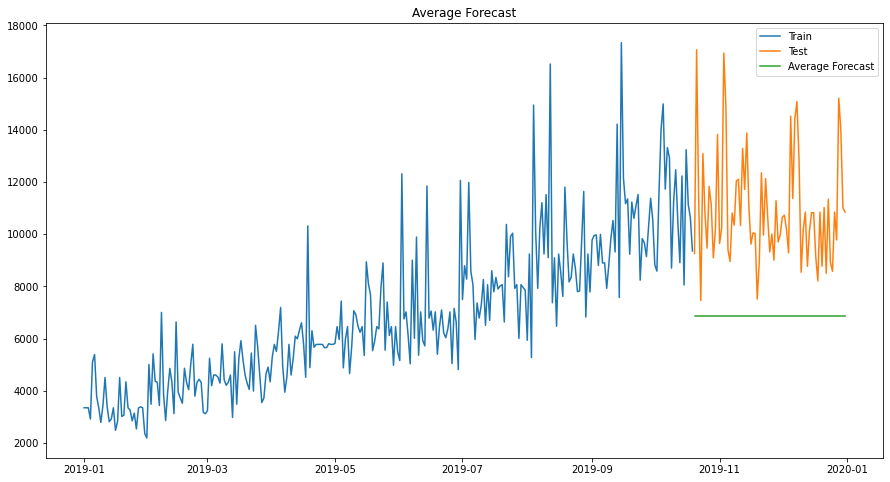

In [23]:
# исходим, что среднее значение трейна будет всегда

y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Mean_inv'].mean()
plt.figure(figsize=(15,8))
plt.plot(train.index, train['Mean_inv'], label='Train')
plt.plot(test.index, test['Mean_inv'], label='Test')
plt.plot(y_hat_avg.index, y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.title('Average Forecast')

In [24]:
rms = sqrt(mean_squared_error(test['Mean_inv'], y_hat_avg['avg_forecast']))
models_quality_rmse['avg_forecast'] = rms
rms # rmse говорит о том, что это тут оказался ещё хуже, чем наивный,
# так же мог бы подойти для стабильных данных

4524.067534877226

Метод 3. Скользящее среднее.

Text(0.5, 1.0, 'Moving Average Forecast')

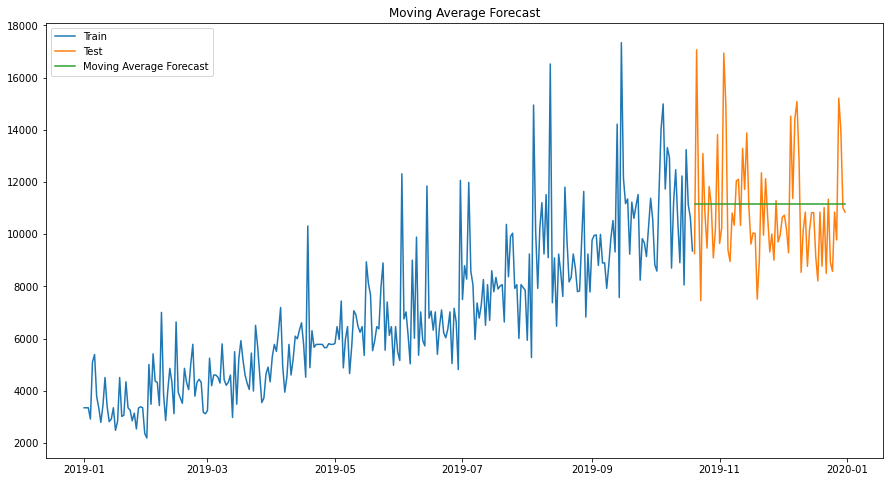

In [25]:
# исходим, что последние периоды (размера n) важнее прошлых 
# и только они участвуют в прогнозе - важно подобрать этот n

y_hat_slice_avg = test.copy()
y_hat_slice_avg['moving_avg_forecast'] = train['Mean_inv'].rolling(21).mean().iloc[-1]
plt.figure(figsize=(15,8))
plt.plot(train.index, train['Mean_inv'], label='Train')
plt.plot(test.index, test['Mean_inv'], label='Test')
plt.plot(y_hat_slice_avg.index, y_hat_slice_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.title('Moving Average Forecast')

In [26]:
rms=sqrt(mean_squared_error(test['Mean_inv'], y_hat_slice_avg['moving_avg_forecast']))
models_quality_rmse['moving_avg_forecast'] = rms
rms # здесь тоже оказался хуже наивного, но все равно всегда интересен

2061.108265667027

Метод 4 – простое экспоненциальное сглаживание

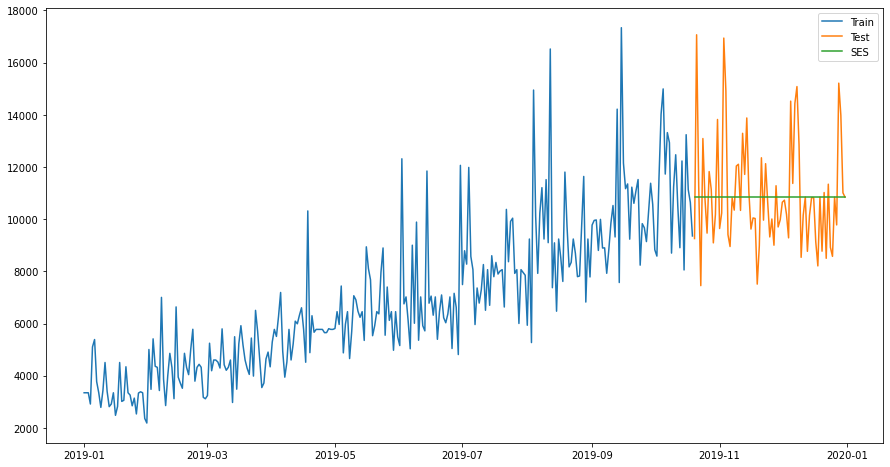

In [27]:
# исходим, что всем точкам даются разные веса, 
# как правило старым меньшие - новым большие (в сумме дадут 1). 
# это взвешенное скользящее среднее

y_hat_exp_slice_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Mean_inv'])).fit(smoothing_level=0.1, optimized=False)
y_hat_exp_slice_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(15,8))
plt.plot(train['Mean_inv'], label='Train')
plt.plot(test['Mean_inv'], label='Test')
plt.plot(y_hat_exp_slice_avg['SES'], label='SES')
plt.legend(loc='best')

In [28]:
rms = sqrt(mean_squared_error(test['Mean_inv'], y_hat_exp_slice_avg['SES']))
models_quality_rmse['SES'] = rms
rms # получилось лучше, 
# но поиграв с настройками SimpleExpSmoothing можно найти решение ещё лучше

2047.226998692552

Метод 5 –  метод линейного тренда Холта

<Figure size 1296x864 with 0 Axes>

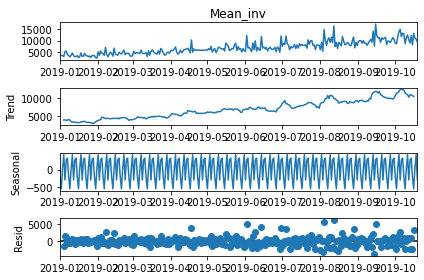

In [29]:
# по сути экспоненциальное сглаживание с учетом тренда

import statsmodels.api as sm
plt.figure(figsize=(18, 12))
sm.tsa.seasonal_decompose(train['Mean_inv']).plot()
result = sm.tsa.stattools.adfuller(train['Mean_inv'])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


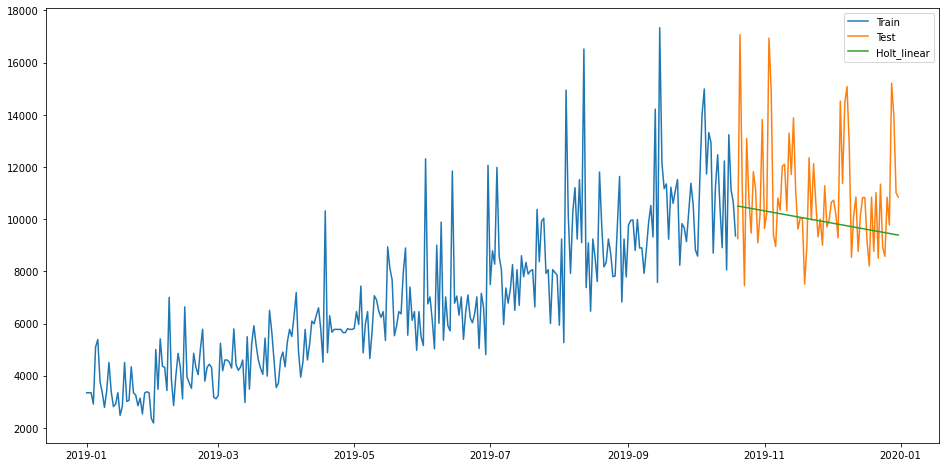

In [30]:
y_hat_holt_avg = test.copy()
fit1 = Holt(np.asarray(train['Mean_inv'])).fit(smoothing_level = 0.3, smoothing_slope = 0.05)
y_hat_holt_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize =(16,8))
plt.plot(train['Mean_inv'], label = 'Train')
plt.plot(test['Mean_inv'], label = 'Test')
plt.plot(y_hat_holt_avg['Holt_linear'], label = 'Holt_linear')
plt.legend(loc='best')

In [31]:
rms = sqrt(mean_squared_error(test['Mean_inv'], y_hat_holt_avg['Holt_linear']))
models_quality_rmse['Holt_linear'] = rms
rms

2253.939376587532

Метод 6 – Метод Холта-Винтера

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


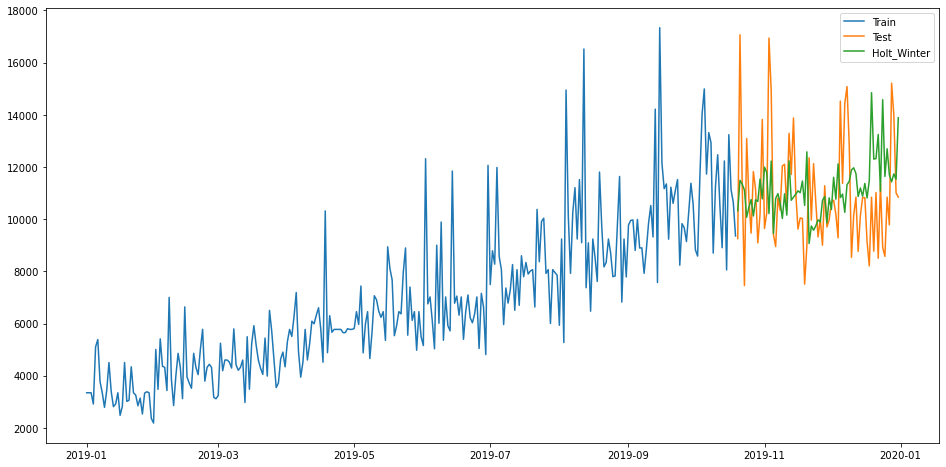

In [32]:
# исходим, что в данных есть сезонность

y_hat_holt_winter_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Mean_inv']), seasonal_periods = 100, trend = 'add', seasonal ='add').fit()
y_hat_holt_winter_avg['Holt_winter'] = fit1.forecast(len(test))
plt.figure(figsize = (16,8))
plt.plot(train['Mean_inv'], label='Train')
plt.plot(test['Mean_inv'], label='Test')
plt.plot(y_hat_holt_winter_avg['Holt_winter'], label='Holt_Winter')
plt.legend(loc='best')

In [33]:
rms = sqrt(mean_squared_error(test['Mean_inv'], y_hat_holt_winter_avg['Holt_winter']))
models_quality_rmse['Holt_Winter'] = rms
rms # лучше всех решений учитывает сезонность, но не идеально

2413.6398958206137

Метод 7 - Seasonal ARIMA

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


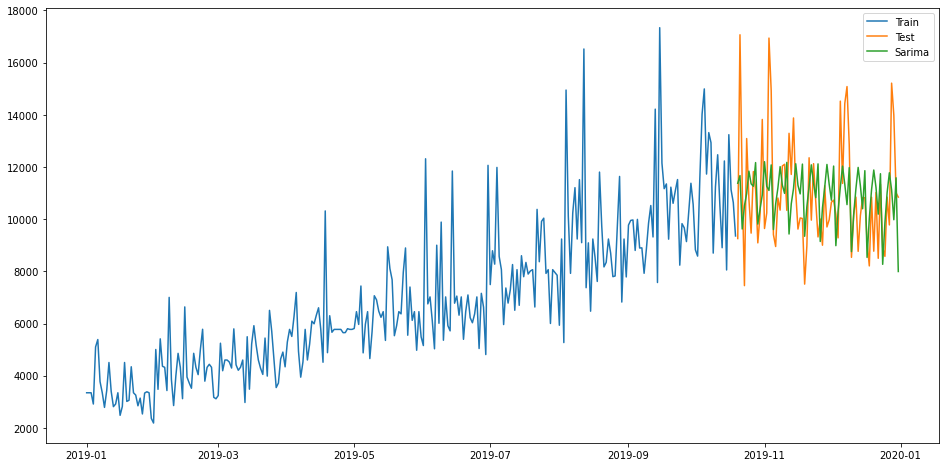

In [34]:
y_hat_sarima_avg = test.copy()
fit1 = SARIMAX(train['Mean_inv'], order=(2, 1, 3), seasonal_order=(1, 2, 4, 7), freq='D').fit() 
y_hat_sarima_avg['Sarima'] = fit1.predict(start='2019-10-20', end='2019-12-31', dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(train['Mean_inv'], label='Train')
plt.plot(test['Mean_inv'], label='Test')
plt.plot(y_hat_sarima_avg['Sarima'], label='Sarima')
plt.legend(loc='best')

In [35]:
rms = sqrt(mean_squared_error(test['Mean_inv'], y_hat_sarima_avg['Sarima']))
models_quality_rmse['sARIMA'] = rms
rms 

2067.336844675631

In [36]:
# выведем ошибку каждой из моделей - sARIMA чуть хуже линейных, но позволяет лучше учесть сезонность, её и используем

pd.DataFrame.from_dict(models_quality_rmse, orient='index', columns=['RMSE'])

,RMSE
native,2573.309125
avg_forecast,4524.067535
moving_avg_forecast,2061.108266
SES,2047.226999
Holt_linear,2253.939377
Holt_Winter,2413.639896
sARIMA,2067.336845


In [37]:
# создадим df для прогноза 

start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime(2020, 12, 31)

res = pd.date_range(
    min(start_date, end_date),
    max(start_date, end_date)
).strftime('%Y-%m-%d').tolist()

df_2020 = pd.DataFrame([0 for i in range(366)], index=res, columns=['Mean_inv'])

In [38]:
# единый df для графика факта и прогноза

df_mean_invoice = df_mean_invoice.append(df_2020).reset_index().set_index('index')
df_mean_invoice.index.set_names(['InvoiceDate_Day'], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


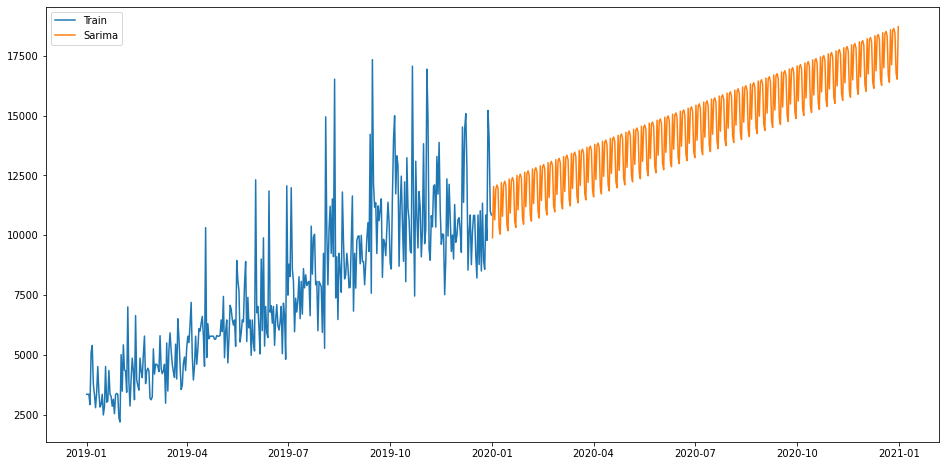

In [39]:
# построим единый график факта и прогноза

y_hat_sarima_avg_new = df_mean_invoice.copy()
fit1 = SARIMAX(df_mean_invoice['Mean_inv'][:365], order=(2, 1, 4), seasonal_order=(1, 1, 2, 7), freq='D').fit() 
y_hat_sarima_avg_new['Mean_inv'][365:] = fit1.predict(start='2020-01-01', end='2020-12-31', dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(df_mean_invoice['Mean_inv'][:365], label='Train')
plt.plot(y_hat_sarima_avg_new['Mean_inv'][365:], label='Sarima')
plt.legend(loc='best')

In [40]:
df_2020 = pd.DataFrame(y_hat_sarima_avg_new['Mean_inv'][366:])
df_2020

,Mean_inv
InvoiceDate_Day,
2020-01-02,12036.489489
2020-01-03,10643.430516
2020-01-04,11926.611084
2020-01-05,12098.454526
2020-01-06,11955.619734
...,...
2020-12-27,18644.669462
2020-12-28,18448.841251
2020-12-29,16788.860966


In [41]:
# сохраним прогноз

df_2020.to_csv('D:\\Work\\data\\online_retail\\forecast.csv')